In [2]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import csv

def find_dicom_images_in_folder(folder_path,folder_path2):
    image_paths = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.lower().endswith('.png'):
                image_paths.append([os.path.join(root, file), os.path.basename(root)])
    i=0
    for root, dirs, files in os.walk(folder_path2):
        for file in files:
            if file.lower().endswith('.png'):
                image_paths[i].append(os.path.join(root, file))
                i+=1
    return image_paths

def save_paths_to_csv(dicom_paths, csv_filename):
    with open(csv_filename, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["Image_Path","Label", "Mask_Path"])
        for path,path2, label in dicom_paths:
            writer.writerow([path,path2, label])

folder_path = "/content/drive/MyDrive/Colab Notebooks/Pulmonary Fibrosis/term2 (1)/7_data_png"
mask_path="/content/drive/MyDrive/Colab Notebooks/Pulmonary Fibrosis/term2 (1)/7_mask_data_png"
dicom_paths = find_dicom_images_in_folder(folder_path,mask_path)
if dicom_paths:
    csv_filename ="data_kayıt.csv"
    save_paths_to_csv(dicom_paths, csv_filename)
    print(f"{len(dicom_paths)} DICOM dosyası CSV dosyasına kaydedildi.")
else:
    print("Belirtilen klasörde DICOM dosyası bulunamadı.")



1488 DICOM dosyası CSV dosyasına kaydedildi.


In [4]:
import pandas as pd
df=pd.read_csv("data_kayıt.csv")
df.head()

,Image_Path,Label,Mask_Path
0,/content/drive/MyDrive/Colab Notebooks/Pulmona...,ground_glass,/content/drive/MyDrive/Colab Notebooks/Pulmona...
1,/content/drive/MyDrive/Colab Notebooks/Pulmona...,ground_glass,/content/drive/MyDrive/Colab Notebooks/Pulmona...
2,/content/drive/MyDrive/Colab Notebooks/Pulmona...,ground_glass,/content/drive/MyDrive/Colab Notebooks/Pulmona...
3,/content/drive/MyDrive/Colab Notebooks/Pulmona...,ground_glass,/content/drive/MyDrive/Colab Notebooks/Pulmona...
4,/content/drive/MyDrive/Colab Notebooks/Pulmona...,ground_glass,/content/drive/MyDrive/Colab Notebooks/Pulmona...


In [ ]:
df.Label.value_counts()

ground_glass     390
fibrosis         386
micronodules     274
consolidation    183
healthy          100
reticulation      89
emphysema         66
Name: Label, dtype: int64

In [5]:
#reticulation_df=df[df["Label"]=="reticulation"]
emphysema_df=df[df["Label"]=="emphysema"]
df = df[(df["Label"] != "emphysema")]

In [ ]:
df.Label.value_counts()

ground_glass     390
fibrosis         386
micronodules     274
consolidation    183
healthy          100
reticulation      89
Name: Label, dtype: int64

In [ ]:
print(df.isnull().sum())
print(df["Image_Path"].apply(type).value_counts())
print(df["Mask_Path"].apply(type).value_counts())
print(df["Label"].apply(type).value_counts())


Image_Path    0
Label         0
Mask_Path     0
dtype: int64
<class 'str'>    1422
Name: Image_Path, dtype: int64
<class 'str'>    1422
Name: Mask_Path, dtype: int64
<class 'str'>    1422
Name: Label, dtype: int64


In [6]:
df["Image_Path"]=df["Image_Path"].astype(str)
df["Mask_Path"]=df["Mask_Path"].astype(str)
df["Label"]=df["Label"].astype(str)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1422 entries, 0 to 1487
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Image_Path  1422 non-null   object
 1   Label       1422 non-null   object
 2   Mask_Path   1422 non-null   object
dtypes: object(3)
memory usage: 44.4+ KB


In [7]:
import tensorflow
from  tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
df.Label=df.Label.replace({"ground_glass":0, "fibrosis":1 ,"micronodules":2 ,"consolidation":3,"healthy":4,"reticulation":5})
df.Label = df.Label.astype(str)
datagen = ImageDataGenerator()

target_size=(128,128)

train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
print(train_df.head())
# Create separate data generators for training and validation
train_data_generator = ImageDataGenerator(
    # Your data augmentation and preprocessing parameters here
).flow_from_dataframe(
    dataframe=train_df,
    x_col="Image_Path",
    y_col="Label",
    batch_size=16,
    seed=42,
    class_mode='sparse',
    shuffle=True,
    target_size=target_size,
)

val_data_generator = ImageDataGenerator().flow_from_dataframe(
    dataframe=val_df,
    x_col="Image_Path",
    y_col="Label",
    batch_size=16,
    seed=42,
    class_mode='sparse',
    shuffle=False,  # No need to shuffle validation data
    target_size=target_size,
)

                                             Image_Path Label  \
999   /content/drive/MyDrive/Colab Notebooks/Pulmona...     2   
590   /content/drive/MyDrive/Colab Notebooks/Pulmona...     1   
188   /content/drive/MyDrive/Colab Notebooks/Pulmona...     0   
297   /content/drive/MyDrive/Colab Notebooks/Pulmona...     0   
1067  /content/drive/MyDrive/Colab Notebooks/Pulmona...     3   

                                              Mask_Path  
999   /content/drive/MyDrive/Colab Notebooks/Pulmona...  
590   /content/drive/MyDrive/Colab Notebooks/Pulmona...  
188   /content/drive/MyDrive/Colab Notebooks/Pulmona...  
297   /content/drive/MyDrive/Colab Notebooks/Pulmona...  
1067  /content/drive/MyDrive/Colab Notebooks/Pulmona...  
Found 1137 validated image filenames belonging to 6 classes.
Found 285 validated image filenames belonging to 6 classes.


In [8]:
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
base_model=InceptionResNetV2(weights='imagenet',include_top=False, input_shape=(128, 128, 3))

219055592/219055592 [==============================] - 11s 0us/step


In [9]:
from keras.models import Model

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation = 'relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(6, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

In [10]:
from keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.1, momentum=0.9), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [11]:
import tensorflow as tf
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')

history = model.fit(train_data_generator,
                    steps_per_epoch=1137   //16,
                    epochs = 20,
                    validation_data=val_data_generator,
                    validation_steps= 285 // 16,
                    callbacks = [callback])

Epoch 1/20
71/71 [==============================] - 636s 8s/step - loss: 1.2863 - accuracy: 0.5361 - val_loss: 78.2062 - val_accuracy: 0.4890
Epoch 2/20
71/71 [==============================] - 404s 6s/step - loss: 0.6768 - accuracy: 0.7707 - val_loss: 2.1300 - val_accuracy: 0.6434
Epoch 3/20
71/71 [==============================] - 408s 6s/step - loss: 0.6875 - accuracy: 0.7734 - val_loss: 10.2557 - val_accuracy: 0.3162
Epoch 4/20
71/71 [==============================] - 409s 6s/step - loss: 0.7140 - accuracy: 0.7698 - val_loss: 2.0581 - val_accuracy: 0.3640
Epoch 5/20
71/71 [==============================] - 405s 6s/step - loss: 0.4837 - accuracy: 0.8412 - val_loss: 1.1299 - val_accuracy: 0.7500
Epoch 6/20
71/71 [==============================] - 409s 6s/step - loss: 0.2678 - accuracy: 0.8885 - val_loss: 0.9387 - val_accuracy: 0.7463
Epoch 7/20
71/71 [==============================] - 407s 6s/step - loss: 0.6545 - accuracy: 0.8171 - val_loss: 9.1346 - val_accuracy: 0.3713
Epoch 8/20


18/18 [==============================] - 28s 1s/step
              precision    recall  f1-score   support

           0       0.92      0.57      0.70        81
           1       0.71      1.00      0.83        77
           2       1.00      0.90      0.95        50
           3       0.61      0.70      0.65        43
           4       0.90      0.90      0.90        10
           5       0.73      0.67      0.70        24

    accuracy                           0.78       285
   macro avg       0.81      0.79      0.79       285
weighted avg       0.81      0.78      0.78       285



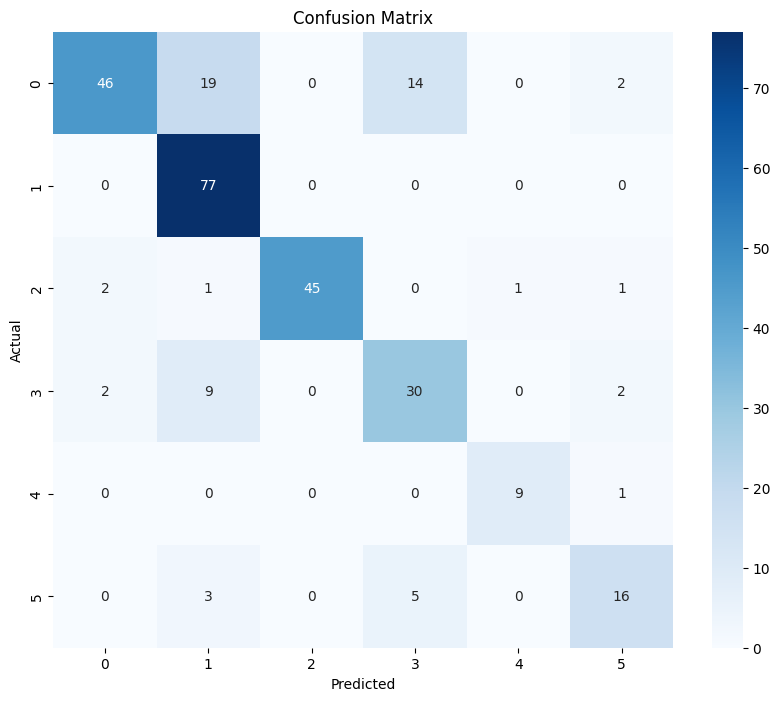

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Tahminleri al (modeliniz ve data generator'ınızın class_mode'u 'categorical' ise bu şekilde çalışır)
val_pred = model.predict(val_data_generator, steps=np.ceil(val_data_generator.samples / val_data_generator.batch_size))
val_pred_classes = np.argmax(val_pred, axis=1)

# Gerçek etiketleri al
val_labels = val_data_generator.classes

# Classification report
print(classification_report(val_labels, val_pred_classes, target_names=list(val_data_generator.class_indices.keys())))

# Confusion matrix
cm = confusion_matrix(val_labels, val_pred_classes)

# Confusion matrix'i renkli olarak çizdir
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=val_data_generator.class_indices, yticklabels=val_data_generator.class_indices)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()